In [18]:
import os 
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/ky_moon/Desktop/bigcon/data_with_residual.csv')
df = df.drop('Unnamed: 0', axis=1)
test_data = pd.read_csv('C:/Users/ky_moon/Desktop/bigcon/test_data.csv')
test_data = test_data.drop('Unnamed: 0', axis=1)
df.head()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,year,fitted,residual
0,2015-12-28,18.827252,48.332993,42.723972,13.288000,111.280,114.305,2015,13.080134,0.207866
1,2016-01-04,15.008106,47.931973,29.411020,12.855000,109.814,112.292,2016,12.971560,-0.116560
2,2016-01-11,15.327347,47.514286,32.301088,12.876667,108.948,111.120,2016,13.031678,-0.155012
3,2016-01-18,15.330000,47.386531,38.159864,13.386667,109.228,111.312,2016,13.099202,0.287464
4,2016-01-25,19.857103,47.281633,40.924449,12.645000,109.566,111.866,2016,12.996417,-0.351417


In [92]:
df.tail()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,year,fitted,residual
205,2019-12-02,22.075649,45.738435,40.963268,14.951667,112.258,109.802,2019,15.251927,-0.300261
206,2019-12-09,21.088546,45.638435,40.308163,16.568333,112.106,109.754,2019,15.695320,0.873014
207,2019-12-16,9.965649,45.819728,41.951299,17.718333,114.012,111.804,2019,15.900109,1.818224
208,2019-12-23,15.443506,46.073810,42.861039,17.015000,114.398,112.208,2019,15.779960,1.235040
209,2019-12-30,28.764278,46.034014,41.350690,17.485000,114.455,112.195,2019,15.541762,1.943238


In [3]:
test_data['WIND_SPEED'] = (test_data['WIND_SPEED'].interpolate('linear', axis = 0) + test_data['WIND_SPEED'].interpolate('quadratic', axis = 0) + test_data['WIND_SPEED'].interpolate('cubic', axis = 0)) / 3
test_data['AIR_TEMP'] = (test_data['AIR_TEMP'].interpolate('linear', axis = 0) + test_data['AIR_TEMP'].interpolate('quadratic', axis = 0) + test_data['AIR_TEMP'].interpolate('cubic', axis = 0)) / 3  # 결측치 내삽

In [4]:
test_data['WIND_SPEED'] = test_data['WIND_SPEED'].interpolate('linear', axis = 0)
test_data['AIR_TEMP'] = test_data['AIR_TEMP'].interpolate('linear', axis = 0)

In [5]:
print(df.shape)
print(test_data.shape)

(210, 10)
(52, 9)


* DataFrame : 외부 데이터 변수, P_PRICE, P_PRICE에대한 fbprophet예측값, 잔차 정보
* 임시로 19년도 까지의 데이터를 train, 20년도 데이터를 test로 설정

#### 변수 설정

In [6]:
# 잔차에 대한 이동평균 정보 추가 (시점에 대한 정보 제공)

res = df[['DATE', 'residual']]
MA4 = res.rolling(window=4, min_periods=1).mean() # 4주 기준으로 이동평균 계산
df['MA4'] = MA4

res = test_data[['DATE', 'residual']]
MA4 = res.rolling(window=4, min_periods=1).mean() # 4주 기준으로 이동평균 계산
test_data['MA4'] = MA4

In [7]:
df.head(3)

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,year,fitted,residual,MA4
0,2015-12-28,18.827252,48.332993,42.723972,13.288000,111.280,114.305,2015,13.080134,0.207866,0.207866
1,2016-01-04,15.008106,47.931973,29.411020,12.855000,109.814,112.292,2016,12.971560,-0.116560,0.045653
2,2016-01-11,15.327347,47.514286,32.301088,12.876667,108.948,111.120,2016,13.031678,-0.155012,-0.021235


In [8]:
test_data.tail(3)

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,fitted,residual,MA4
49,2020-12-14,8.725,NaN,52.225,14.571429,116.4580,113.358,15.871019,-1.299590,-0.814728
50,2020-12-21,8.725,NaN,52.225,14.864286,115.3480,112.254,15.800262,-0.935976,-0.988243
51,2020-12-28,8.725,NaN,52.225,15.207143,116.5025,113.345,15.561504,-0.354361,-0.924434


In [9]:
df1 = df[['DATE', 'WIND_SPEED', 'AIR_TEMP', 'Broad', 'MA4', 'residual']]  

y_train = df1['residual']
X_train = df1[['WIND_SPEED', 'AIR_TEMP', 'Broad', 'MA4']] # 19년도 데이터가 train set

test_data1 = test_data[['DATE', 'WIND_SPEED', 'AIR_TEMP', 'Broad', 'MA4', 'residual']]  # 20년도 데이터가 test_set

y_test = test_data1['residual']
X_test = test_data1[['WIND_SPEED', 'AIR_TEMP', 'Broad', 'MA4']]

In [10]:
X_train.head(3)

,WIND_SPEED,AIR_TEMP,Broad,MA4
0,18.827252,42.723972,111.280,0.207866
1,15.008106,29.411020,109.814,0.045653
2,15.327347,32.301088,108.948,-0.021235


In [11]:
X_test.head(3)

,WIND_SPEED,AIR_TEMP,Broad,MA4
0,26.740816,42.972109,113.618,1.560393
1,20.370852,43.171588,113.978,1.716144
2,25.564932,40.979687,113.504,1.190812


In [12]:
X_test.tail()

,WIND_SPEED,AIR_TEMP,Broad,MA4
47,8.725,52.225,116.6540,-0.483219
48,8.725,52.225,117.5200,-0.625405
49,8.725,52.225,116.4580,-0.814728
50,8.725,52.225,115.3480,-0.988243
51,8.725,52.225,116.5025,-0.924434


#### 회귀분석

In [36]:
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()   
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlr = LinearRegression()
mlr.fit(X_train, y_train) 

LinearRegression()

In [37]:
lr_predict = mlr.predict(X_test)

In [38]:
compare = pd.DataFrame(y_test)
compare['lr_predicted'] = list(lr_predict)
compare['lr_error'] = compare['residual'] - compare['lr_predicted']

In [39]:
sse = 0
for err in compare['lr_error']:
    se = err**2
    sse += se
mse = sse / compare.shape[0]
print(mse)

0.5818037944205787


#### 변수 중요도 (회귀 계수 비교)

In [48]:
coef = mlr.coef_
coef

array([-5.94267789e-04,  7.56124183e-04, -2.55956311e-03,  9.90389191e-01])

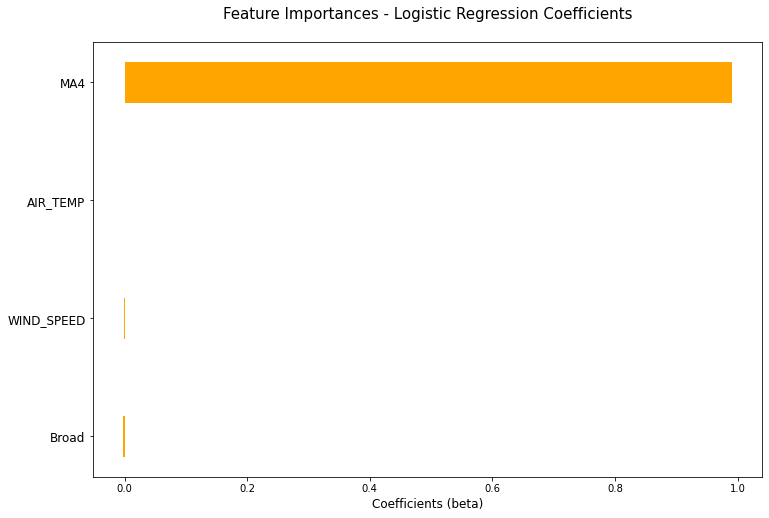

In [49]:
indices =  np.argsort(coef)  # 회귀계수 크기 순으로 정렬

plt.figure(figsize=(12, 8))
plt.barh(X_test.columns, coef[indices], .35, color='orange', align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)
plt.xlabel('Coefficients (beta)', fontsize=12)
plt.title('Feature Importances - Logistic Regression Coefficients\n', fontsize=15)
plt.show()

#### 회귀분석 : Ridge

In [50]:
ridge = Ridge()

param_grid = {
    'alpha': [0.1, 0.5, 1, 1.5, 2]
}
grid_search = GridSearchCV(ridge, param_grid=param_grid) 

In [54]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(estimator=Ridge(), param_grid={'alpha': [0.1, 0.5, 1, 1.5, 2]})

In [55]:
grid_search.best_estimator_

Ridge(alpha=2)

In [56]:
ridge = Ridge(alpha=2)
ridge.fit(X_train, y_train)
ridge_predict = ridge.predict(X_test)

In [57]:
compare = pd.DataFrame(y_test)
compare['ridge_predicted'] = list(ridge_predict)
compare['ridge_error'] = compare['residual'] - compare['ridge_predicted']

In [58]:
sse = 0
for err in compare['ridge_error']:
    se = err**2
    sse += se
mse = sse / compare.shape[0]
print(mse)

0.5828002381641999


#### 변수 중요도 (회귀 계수 비교)

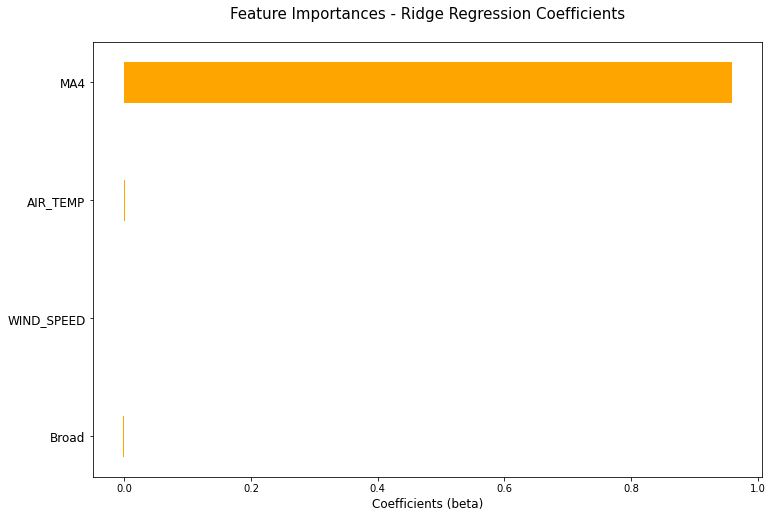

In [100]:
coef = ridge.coef_
indices =  np.argsort(coef)  # 회귀계수 크기 순으로 정렬

plt.figure(figsize=(12, 8))
plt.barh(X_test.columns, coef[indices], .35, color='orange', align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)
plt.xlabel('Coefficients (beta)', fontsize=12)
plt.title('Feature Importances - Ridge Regression Coefficients\n', fontsize=15)
plt.show()

In [103]:
X_test.columns

Index(['WIND_SPEED', 'AIR_TEMP', 'Broad', 'MA4'], dtype='object')

In [104]:
coef[indices]

array([-1.97297967e-03, -1.18401151e-04,  1.08375875e-03,  9.58991378e-01])

#### KNN

In [161]:
param_grid = [{'n_neighbors': [10,20,25,30,35,40,45,50]}]
knn_reg = KNeighborsRegressor()
grid_knn = GridSearchCV(knn_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': [10, 20, 25, 30, 35, 40, 45, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [165]:
grid_knn.best_params_

{'n_neighbors': 10}

In [171]:
knn_reg = KNeighborsRegressor(n_neighbors=10)
knn_reg.fit(X_train, y_train)
knn_predict = grid_knn.predict(X_test)

compare['knn_predicted'] = list(knn_predict)
compare['knn_error'] = compare['residual'] - compare['knn_predicted']

In [172]:
sse = 0
for err in compare['knn_error']:
    se = err**2
    sse += se
mse = sse / compare.shape[0]
print(mse)

2.1697567277996543


#### RandomForest Regressor

In [61]:
param_grid = [
        {'n_estimators': [3, 5, 7, 10, 50], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 5, 10], 'max_features': [2, 3, 4]},
    ]
rf_reg = RandomForestRegressor()
 
grid_search = GridSearchCV(rf_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
 
grid_search.fit(X_train, y_train)

C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\paralle

C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\paralle

C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\paralle

C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\ky_moon\AppData\Roaming\Python\Python37\site-packages\joblib\paralle

C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [-0.36817291 -0.32276682 -0.34558337 -0.31988474 -0.29155086 -0.32616511
 -0.33286629 -0.30498981 -0.3292401  -0.28994799         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -0.36384742 -0.37008431 -0.35495295 -0.4975542
 -0.48000045 -0.41284576 -0.62657478 -0.62493247 -0.63832272]
  category=UserWarning
C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the train scores are non-finite: [-9.12664534e-02 -7.78889834e-02 -7.07025406e-02 -5.69675451e-02
 -4.02464493e-02 -8.13504169e-02 -8.19442169e-02 -6.57110778e-02
 -5.70782074e-02 -4.38058906e-02             nan             nan
             nan             nan             nan             nan
             nan             nan         

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 5, 7, 10, 50]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 5, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [62]:
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=50)

In [63]:
rf_reg = RandomForestRegressor(max_features=2, n_estimators=50)

rf_reg.fit(X_train, y_train)
rf_predict = rf_reg.predict(X_test)

compare['rf_predicted'] = list(rf_predict)
compare['rf_error'] = compare['residual'] - compare['rf_predicted']

In [64]:
sse = 0
for err in compare['rf_error']:
    se = err**2
    sse += se
mse = sse / compare.shape[0]
print(mse)

0.9553340533166341


#### 변수 중요도 : Mean Decrease Impurity

In [66]:
importances =  rf_reg.feature_importances_
importances

array([0.13265475, 0.12703242, 0.16118549, 0.57912734])

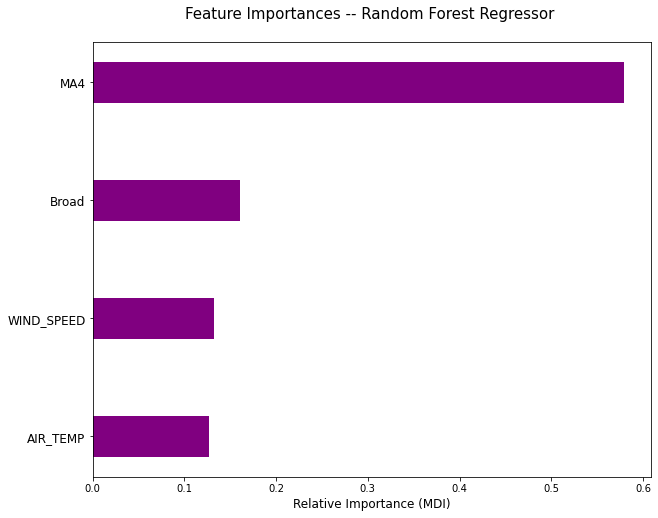

In [68]:
indices = np.argsort(importances)     # 중요도 크기 순으로 정렬

plt.figure(figsize=(10, 8))

plt.barh(X_test.columns, importances[indices], .35, color='purple', align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)

plt.xlabel('Relative Importance (MDI)', fontsize=12)
plt.title('Feature Importances -- Random Forest Regressor \n', fontsize=15)
plt.show()

#### 변수 중요도 : Permutation Importance 

In [72]:
import eli5  # conda install -c conda-forge eli5

from eli5.sklearn import PermutationImportance

imp = PermutationImportance(rf_reg, random_state=1).fit(X_test, y_test)
imp

PermutationImportance(estimator=RandomForestRegressor(max_features=2,
                                                      n_estimators=50),
                      random_state=1)

In [106]:
X_train

,WIND_SPEED,AIR_TEMP,Broad,MA4
0,18.827252,42.723972,111.280,0.207866
1,15.008106,29.411020,109.814,0.045653
2,15.327347,32.301088,108.948,-0.021235
3,15.330000,38.159864,109.228,0.055940
4,19.857103,40.924449,109.566,-0.083881
...,...,...,...,...
205,22.075649,40.963268,112.258,-0.088668
206,21.088546,40.308163,112.106,0.247012
207,9.965649,41.951299,114.012,0.660169
208,15.443506,42.861039,114.398,0.906504


In [105]:
y_train

0      0.207866
1     -0.116560
2     -0.155012
3      0.287464
4     -0.351417
         ...   
205   -0.300261
206    0.873014
207    1.818224
208    1.235040
209    1.943238
Name: residual, Length: 210, dtype: float64

In [73]:
eli5.show_weights(imp, feature_names = X_test.columns.tolist())

Weight,Feature
0.8503 ± 0.1543,MA4
0.0325 ± 0.0298,AIR_TEMP
0.0100 ± 0.0192,WIND_SPEED
0.0067 ± 0.0073,Broad


In [74]:
print(eli5.format_as_text(eli5.explain_weights(imp, feature_names = X_test.columns.tolist())))

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.8503 ± 0.1543  MA4
0.0325 ± 0.0298  AIR_TEMP
0.0100 ± 0.0192  WIND_SPEED
0.0067 ± 0.0073  Broad


#### XGBoost Regressor

In [75]:
params = {'learning_rate': [0.03, 0.05, 0.07], 
            'max_depth': [3, 5, 6, 7],
            'min_child_weight': [1, 2, 4],
            'n_estimators': [10, 20, 30, 50]}

xgb = XGBRegressor() 

grid = GridSearchCV(xgb, params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [76]:
grid.best_params_

{'learning_rate': 0.07,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 50}

In [77]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
xgb_reg = XGBRegressor(learning_rate=0.07,
                       max_depth=3,
                       min_child_weight=1,
                       n_estimators=50) 

xgb_reg.fit(X_train, y_train)
xgb_predict = xgb_reg.predict(X_test)

compare['xgb_predicted'] = list(xgb_predict)
compare['xgb_error'] = compare['residual'] - compare['xgb_predicted']

In [79]:
sse = 0
for err in compare['xgb_error']:
    se = err**2
    sse += se
mse = sse / compare.shape[0]
print(mse)

1.0022659833160885


#### 변수 중요도 

In [80]:
importances =  xgb_reg.feature_importances_
importances  

array([0.08542143, 0.09733431, 0.12471913, 0.69252515], dtype=float32)

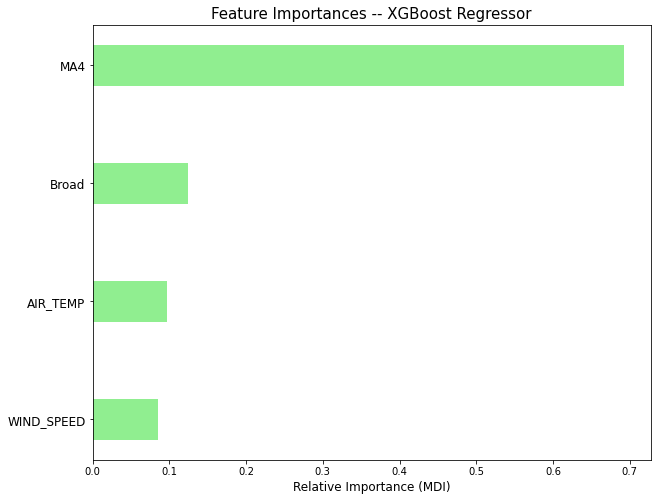

In [82]:
indices = np.argsort(importances)  # 중요도 크기 순으로 정렬

plt.figure(figsize=(10, 8))

plt.barh(X_test.columns, importances[indices], .35, color='lightgreen', align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)

plt.xlabel('Relative Importance (MDI)', fontsize=12)
plt.title('Feature Importances -- XGBoost Regressor', fontsize=15)
plt.show()

#### Permutation Importance

In [88]:
imp = PermutationImportance(xgb_reg, random_state=1).fit(X_test, y_test)
imp

PermutationImportance(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             gpu_id=-1, importance_type='gain',
                                             interaction_constraints='',
                                             learning_rate=0.07,
                                             max_delta_step=0, max_depth=3,
                                             min_child_weight=1, missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=50, n_jobs=8,
                                             num_parallel_tree=1,
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, s

In [89]:
eli5.show_weights(imp, feature_names = X_test.columns.tolist())

Weight,Feature
0.8071 ± 0.1625,MA4
0.0042 ± 0.0624,AIR_TEMP
0.0036 ± 0.0085,Broad
-0.0013 ± 0.0618,WIND_SPEED


In [90]:
print(eli5.format_as_text(eli5.explain_weights(imp, feature_names = X_test.columns.tolist())))

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.8071 ± 0.1625  MA4
0.0042 ± 0.0624  AIR_TEMP
0.0036 ± 0.0085  Broad
-0.0013 ± 0.0618  WIND_SPEED


#### Lightgbm regressor

In [83]:
params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

grid = GridSearchCV(lgb.LGBMRegressor(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.03, 0.003],
                         'max_depth': [-1, 3, 5],
                         'n_estimators': [50, 100, 200, 500],
                         'num_leaves': [7, 14, 21, 28, 31, 50]},
             scoring='r2')

In [84]:
grid.best_params_

{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 7}

In [85]:
grid.best_estimator_

LGBMRegressor(learning_rate=0.03, max_depth=3, num_leaves=7)

In [86]:
lgb_reg = lgb.LGBMRegressor(learning_rate=0.03, max_depth=3, num_leaves=7)
lgb_reg.fit(X_train, y_train)
lgb_predict = lgb_reg.predict(X_test)

compare['lgb_predicted'] = list(lgb_predict)
compare['lgb_error'] = compare['residual'] - compare['lgb_predicted']

In [87]:
sse = 0
for err in compare['lgb_error']:
    se = err**2
    sse += se
mse = sse / compare.shape[0]
print(mse)

0.9633759313723792


#### 변수 중요도

In [93]:
importances =  lgb_reg.feature_importances_
importances

array([ 96,  55,  91, 241])

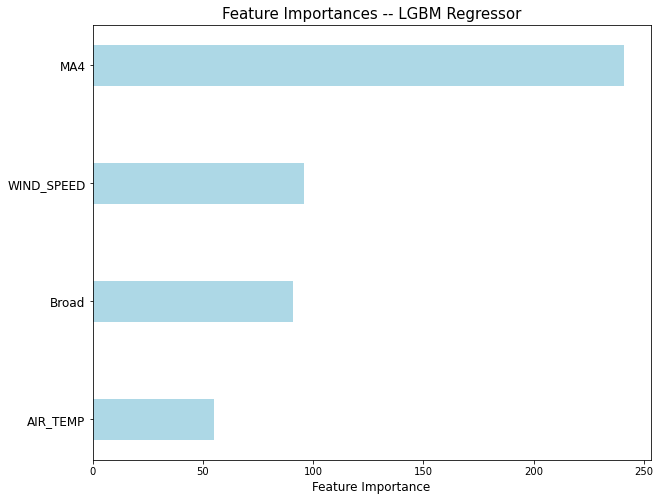

In [96]:
indices =  np.argsort(importances)                  # 중요도 크기 순으로 정렬

plt.figure(figsize=(10, 8))
plt.barh(X_test.columns, importances[indices], .35, color='lightblue', align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)

plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importances -- LGBM Regressor', fontsize=15)
plt.show()

#### Permutation Importance

In [97]:
imp = PermutationImportance(lgb_reg, random_state=1).fit(X_test, y_test)
imp

PermutationImportance(estimator=LGBMRegressor(learning_rate=0.03, max_depth=3,
                                              num_leaves=7),
                      random_state=1)

In [98]:
eli5.show_weights(imp, feature_names = X_test.columns.tolist())

Weight,Feature
0.7553 ± 0.1417,MA4
0.0146 ± 0.0122,AIR_TEMP
-0.0006 ± 0.0227,Broad
-0.0013 ± 0.0173,WIND_SPEED


In [99]:
print(eli5.format_as_text(eli5.explain_weights(imp, feature_names = X_test.columns.tolist())))

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.7553 ± 0.1417  MA4
0.0146 ± 0.0122  AIR_TEMP
-0.0006 ± 0.0227  Broad
-0.0013 ± 0.0173  WIND_SPEED
